In [1]:
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm
import multiprocessing
import cv2

In [2]:
import warnings
warnings.filterwarnings("ignore")

# EDA

Load class dictionary

In [3]:
input_path = "../input/deepglobe-land-cover-classification-dataset"

In [4]:
df = pd.read_csv(os.path.join(input_path, 'class_dict.csv'))
df

,name,r,g,b
0,urban_land,0,255,255
1,agriculture_land,255,255,0
2,rangeland,255,0,255
3,forest_land,0,255,0
4,water,0,0,255
5,barren_land,255,255,255
6,unknown,0,0,0


Number of images and masks in train dataset

In [5]:
train_path = os.path.join(input_path, 'train')

train_images = [f for f in os.listdir(train_path) if f.endswith("_sat.jpg")]
train_masks = [f for f in os.listdir(train_path) if f.endswith("_mask.png")]

print(f"Total Images: {len(train_images)}")
print(f"Total Masks: {len(train_masks)}")

Total Images: 803
Total Masks: 803


Number of images and masks in validation dataset

In [6]:
valid_path = os.path.join(input_path, 'valid')

valid_images = [f for f in os.listdir(valid_path) if f.endswith("_sat.jpg")]
valid_masks = [f for f in os.listdir(valid_path) if f.endswith("_mask.png")]

print(f"Total Images: {len(valid_images)}")
print(f"Total Masks: {len(valid_masks)}")

Total Images: 171
Total Masks: 0


Visualize an image and mask

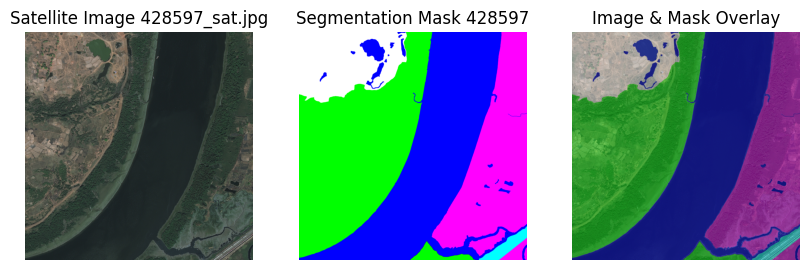

In [7]:
image_name = random.choice(train_images)
base_name = image_name.split("_")[0]
image_path = f"{train_path}/{base_name}_sat.jpg"
mask_path = f"{train_path}/{base_name}_mask.png"


image = Image.open(image_path)
mask = Image.open(mask_path)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(image)
ax[0].set_title(f"Satellite Image {base_name}_sat.jpg")
ax[0].axis("off")

ax[1].imshow(mask)
ax[1].set_title(f"Segmentation Mask {base_name}")
ax[1].axis("off")

plt.imshow(image)
plt.imshow(mask, alpha=0.4)
plt.title("Image & Mask Overlay")
plt.axis("off")

plt.show()

Image and mask size

In [8]:
img_size = []
mask_size = []

for img_name,mask_name in zip(train_images, train_masks):
  image = Image.open(f"{train_path}/{img_name}")
  mask = Image.open(f"{train_path}/{mask_name}")

  img_size.append(image.size)
  mask_size.append(mask.size)

print(f"Unique Image Sizes: {len(set(img_size))}")
print(f"Unique Mask Sizes: {len(set(mask_size))}")
print("---------------------------")

if len(set(img_size)) == 1 and len(set(mask_size)) == 1:
  print(f"Image Size: {img_size[0]}")
  print(f"Mask Size: {mask_size[0]}")
else:
  print(f"Image Size: {set(img_size)}")
  print(f"Mask Size: {set(mask_size)}")

Unique Image Sizes: 1
Unique Mask Sizes: 1
---------------------------
Image Size: (2448, 2448)
Mask Size: (2448, 2448)


Check number of channels

In [9]:
num_channels = []

for img_name in train_images:
  image = Image.open(f"{train_path}/{img_name}")

  if image.mode != "RGB":
    num_channels.append(image)

print(f"Number of RGB images: {len(train_images) - len(num_channels)}")
print(f"Number of other images: {len(num_channels)}")

Number of RGB images: 803
Number of other images: 0


In [10]:
image_np = np.array(image)
mask_np = np.array(mask)

print(f"Image Shape: {image_np.shape}")
print(f"Mask Shape: {mask_np.shape}")
print(np.unique(np.array(mask)))

Image Shape: (2448, 2448, 3)
Mask Shape: (2448, 2448, 3)
[  0 255]


# Data preprocessing

In [11]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import glob

Model parameters

In [12]:
class Parameters():
  lr = 0.001
  batch_size_train = 8
  batch_size_val = 16
  epochs = 100
  in_channels = 3
  num_classes = 7

params = Parameters()

Resize and normalize images, convert mask RGB values to categorical values, convert to PyTorch tensors

In [13]:
def rgb_to_categorical(mask):
    mask_np = np.array(mask)
    category_mask = np.zeros(mask_np.shape[:2], dtype=np.int8)
    for i, row in df.iterrows():
        category_mask += (np.all(mask_np.reshape((-1, 3)) == (row['r'], row['g'], row['b']), axis=1).reshape(mask_np.shape[:2]) * i)
    return category_mask

transform_image = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # values from imagenet
])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(lambda mask: rgb_to_categorical(mask)),
    transforms.ToTensor()
])

Create Dataset

In [14]:
class LandCoverDataset(Dataset):
  def __init__(self, image_path, mask_path, transform_image=None, transform_mask=None):
    self.image_path = image_path
    self.mask_path = mask_path
    self.transform_image = transform_image
    self.transform_mask = transform_mask

  def __len__(self):
    return len(self.image_path)

  def __getitem__(self, index):
    image = Image.open(self.image_path[index])
    mask = Image.open(self.mask_path[index])

    if self.transform_image:
      image = self.transform_image(image)
    if self.transform_mask:
      mask = self.transform_mask(mask)

    return image, mask

Split dataset

In [15]:
image_paths = sorted(glob.glob(os.path.join(train_path, "*_sat.jpg")))
mask_paths = sorted(glob.glob(os.path.join(train_path, "*_mask.png")))

In [16]:
train_images, val_images, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

Create datasets

In [17]:
train_dataset = LandCoverDataset(train_images, train_masks, transform_image, transform_mask)
val_dataset = LandCoverDataset(val_images, val_masks, transform_image, transform_mask)

Create DataLoader

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=params.batch_size_train, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=params.batch_size_val, shuffle=False)

# Model building - U Net

In [19]:
!pip install --upgrade torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: torchmetrics
    Found existing installation: torchmetrics 1.6.1
    Uninstalling torchmetrics-1.6.1:
      Successfully uninstalled torchmetrics-1.6.1


In [20]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics.segmentation import DiceScore
from IPython.display import FileLink

In [21]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
    )

  def forward(self, x):
    return self.double_conv(x)

class DownBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = DoubleConv(in_channels, out_channels)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    down = self.conv(x)
    p = self.pool(down)
    return down, p

class UpBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
    self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1)
    x = torch.cat([x1, x2], 1)
    return self.conv(x)


class LandCoverCNN(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    # Encoder block
    self.down_conv1 = DownBlock(in_channels, 64)
    self.down_conv2 = DownBlock(64, 128)
    self.down_conv3 = DownBlock(128, 256)
    self.down_conv4 = DownBlock(256, 512)

    # Bottle neck
    self.bottle_neck  = DoubleConv(512, 1024)

    # Decoder block
    self.up_conv1 = UpBlock(1024, 512)
    self.up_conv2 = UpBlock(512, 256)
    self.up_conv3 = UpBlock(256, 128)
    self.up_conv4 = UpBlock(128, 64)

    # Out block
    self.out = nn.Conv2d(64, num_classes, kernel_size=1)

  def forward(self, x):
    down1, p1 = self.down_conv1(x)
    down2, p2 = self.down_conv2(p1)
    down3, p3 = self.down_conv3(p2)
    down4, p4 = self.down_conv4(p3)

    b = self.bottle_neck(p4)

    up1 = self.up_conv1(b, down4)
    up2 = self.up_conv2(up1, down3)
    up3 = self.up_conv3(up2, down2)
    up4 = self.up_conv4(up3, down1)

    out = self.out(up4)

    return out

In [22]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = LandCoverCNN(in_channels=params.in_channels, num_classes=params.num_classes).to(device)

Loss function and optimizer

In [23]:
weights  = torch.tensor([0.58, 0.11, 0.01, 0.08, 0.03, 0.11, 0.08], dtype=torch.float)
loss_fn = nn.CrossEntropyLoss(weight=weights) # Add weight or implement Focalloss - dataset is imbalance

optimizer = optim.Adam(model.parameters(), lr=params.lr)

dice = DiceScore(num_classes=params.num_classes, average='micro')

*Training* and *validation* loop with metrics

In [24]:
train_losses = []
train_dcs = []
val_losses = []
val_dcs = []

torch.cuda.empty_cache()

for epoch in range(params.epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True) as progress_bar:
        model.train()
        total_loss = 0
        total_dice = 0

        for batch_idx, (image, mask) in enumerate(train_dataloader):
            image = image.to(device)
            mask = mask.to(device).long().squeeze(1)

            # 1. Forward pass
            y_pred = model(image)

            # 2. Calculate loss
            
            loss_fn = loss_fn.to(device)
            loss = loss_fn(y_pred, mask)
    
            # 3. Backward pass - clear gradient from the optimizer
            optimizer.zero_grad()
            loss.backward()
    
            # 4. Update weights
            optimizer.step()
    
            # 5. Calculate metrics
            total_loss += loss.item()
            
            preds = torch.argmax(y_pred, dim=1)
            preds_one_hot = F.one_hot(preds, num_classes=params.num_classes).permute(0, 3, 1, 2).float()
            mask_one_hot = F.one_hot(mask, num_classes=params.num_classes).permute(0, 3, 1, 2).float()
            total_dice += dice(preds_one_hot, mask_one_hot)
    
    
            # Update progress bar
            progress_bar.set_postfix_str(f"Epoch: {epoch}, Avg. train loss: {total_loss / (batch_idx + 1):.4f}, Avg. train Dice: {total_dice / (batch_idx + 1):.4f}")
            progress_bar.update(1)

    # Average metrics
    avg_loss = total_loss / len(train_dataloader)
    avg_dice = total_dice / len(train_dataloader)

    train_losses.append(avg_loss)
    train_dcs.append(avg_dice.cpu().item())

    print("=" * 50)
    print(f"Epoch {epoch+1}/{params.epochs} completed. Starting validation...")
    print("=" * 50)
  # ------------------------------------------------------------------------------------------------------------------------------------------------
  # Validation loop
    model.eval()

    total_val_loss = 0
    total_val_dice = 0

    with torch.no_grad():
        for image, mask in val_dataloader:
            image = image.to(device)
            mask = mask.to(device).long().squeeze(1)

            # 1. Forward pass
            y_pred = model(image)

            # 2. Calculate loss
            loss = loss_fn(y_pred, mask)

            # 3. Calculate metrics
            total_val_loss += loss.item()

            preds = torch.argmax(y_pred, dim=1)
            preds_one_hot = F.one_hot(preds, num_classes=params.num_classes).permute(0, 3, 1, 2).float()
            mask_one_hot = F.one_hot(mask, num_classes=params.num_classes).permute(0, 3, 1, 2).float()
            total_val_dice += dice(preds_one_hot.detach(), mask_one_hot)

    avg_val_loss = total_val_loss / len(val_dataloader)
    avg_val_dice = total_val_dice / len(val_dataloader)

    val_losses.append(avg_val_loss)
    val_dcs.append(avg_val_dice.cpu().item())

    print(f"Avg val loss: {avg_val_loss}, Avg val Dice: {avg_val_dice}", flush=True)
    print("=" * 50)

torch.save(model.state_dict(), '/kaggle/working/unet_model.pth')

metrics_df = pd.DataFrame({
    "epoch": list(range(1, params.epochs + 1)),
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_dice": train_dcs,
    "val_dice": val_dcs,
})
metrics_df.to_csv("/kaggle/working/unet_metrics.csv", index=False)

100%|██████████| 81/81 [02:32<00:00,  1.88s/it, Epoch: 0, Avg. train loss: 1.1512, Avg. train Dice: 0.4195]


Epoch 1/100 completed. Starting validation...
Avg val loss: 0.8451003432273865, Avg val Dice: 0.5370239019393921


100%|██████████| 81/81 [02:25<00:00,  1.80s/it, Epoch: 1, Avg. train loss: 0.8753, Avg. train Dice: 0.5370]


Epoch 2/100 completed. Starting validation...
Avg val loss: 0.7894674756310203, Avg val Dice: 0.6298141479492188


100%|██████████| 81/81 [02:26<00:00,  1.81s/it, Epoch: 2, Avg. train loss: 0.8320, Avg. train Dice: 0.5499]


Epoch 3/100 completed. Starting validation...
Avg val loss: 0.7743060643022711, Avg val Dice: 0.6480631828308105


100%|██████████| 81/81 [02:27<00:00,  1.82s/it, Epoch: 3, Avg. train loss: 0.8142, Avg. train Dice: 0.5515]


Epoch 4/100 completed. Starting validation...
Avg val loss: 0.7280436700040643, Avg val Dice: 0.6078332662582397


100%|██████████| 81/81 [02:27<00:00,  1.82s/it, Epoch: 4, Avg. train loss: 0.8154, Avg. train Dice: 0.5567]


Epoch 5/100 completed. Starting validation...
Avg val loss: 0.7598128156228499, Avg val Dice: 0.6331365704536438


100%|██████████| 81/81 [02:28<00:00,  1.83s/it, Epoch: 5, Avg. train loss: 0.7965, Avg. train Dice: 0.5500]


Epoch 6/100 completed. Starting validation...
Avg val loss: 0.7320021878589283, Avg val Dice: 0.5823154449462891


100%|██████████| 81/81 [02:28<00:00,  1.83s/it, Epoch: 6, Avg. train loss: 0.7835, Avg. train Dice: 0.5540]


Epoch 7/100 completed. Starting validation...
Avg val loss: 0.7383124340664257, Avg val Dice: 0.6301246881484985


100%|██████████| 81/81 [02:27<00:00,  1.83s/it, Epoch: 7, Avg. train loss: 0.7849, Avg. train Dice: 0.5658]


Epoch 8/100 completed. Starting validation...
Avg val loss: 0.7069058364087885, Avg val Dice: 0.6065366864204407


100%|██████████| 81/81 [02:26<00:00,  1.81s/it, Epoch: 8, Avg. train loss: 0.7740, Avg. train Dice: 0.5770]


Epoch 9/100 completed. Starting validation...
Avg val loss: 0.7094811255281622, Avg val Dice: 0.6353665590286255


100%|██████████| 81/81 [02:29<00:00,  1.84s/it, Epoch: 9, Avg. train loss: 0.7547, Avg. train Dice: 0.5789]


Epoch 10/100 completed. Starting validation...
Avg val loss: 0.6866700486703352, Avg val Dice: 0.6017258763313293


100%|██████████| 81/81 [02:28<00:00,  1.84s/it, Epoch: 10, Avg. train loss: 0.7305, Avg. train Dice: 0.5842]


Epoch 11/100 completed. Starting validation...
Avg val loss: 0.6798804239793257, Avg val Dice: 0.6447470784187317


100%|██████████| 81/81 [02:28<00:00,  1.84s/it, Epoch: 11, Avg. train loss: 0.7150, Avg. train Dice: 0.5986]


Epoch 12/100 completed. Starting validation...
Avg val loss: 0.6787873343987898, Avg val Dice: 0.5954180955886841


100%|██████████| 81/81 [02:29<00:00,  1.85s/it, Epoch: 12, Avg. train loss: 0.7203, Avg. train Dice: 0.6046]


Epoch 13/100 completed. Starting validation...
Avg val loss: 0.6686186356977983, Avg val Dice: 0.6375792622566223


100%|██████████| 81/81 [02:29<00:00,  1.85s/it, Epoch: 13, Avg. train loss: 0.7227, Avg. train Dice: 0.6047]


Epoch 14/100 completed. Starting validation...
Avg val loss: 0.6946281790733337, Avg val Dice: 0.5410839319229126


100%|██████████| 81/81 [02:29<00:00,  1.85s/it, Epoch: 14, Avg. train loss: 0.6915, Avg. train Dice: 0.6300]


Epoch 15/100 completed. Starting validation...
Avg val loss: 0.6234870986504988, Avg val Dice: 0.6488004326820374


100%|██████████| 81/81 [02:30<00:00,  1.86s/it, Epoch: 15, Avg. train loss: 0.6694, Avg. train Dice: 0.6444]


Epoch 16/100 completed. Starting validation...
Avg val loss: 0.6320587234063582, Avg val Dice: 0.6321930885314941


100%|██████████| 81/81 [02:27<00:00,  1.83s/it, Epoch: 16, Avg. train loss: 0.6582, Avg. train Dice: 0.6384]


Epoch 17/100 completed. Starting validation...
Avg val loss: 0.6223534453998912, Avg val Dice: 0.6220768094062805


100%|██████████| 81/81 [02:30<00:00,  1.85s/it, Epoch: 17, Avg. train loss: 0.6669, Avg. train Dice: 0.6397]


Epoch 18/100 completed. Starting validation...
Avg val loss: 0.5774165852503343, Avg val Dice: 0.6771277785301208


100%|██████████| 81/81 [02:28<00:00,  1.84s/it, Epoch: 18, Avg. train loss: 0.6401, Avg. train Dice: 0.6527]


Epoch 19/100 completed. Starting validation...
Avg val loss: 0.580157605084506, Avg val Dice: 0.7104398608207703


100%|██████████| 81/81 [02:32<00:00,  1.88s/it, Epoch: 19, Avg. train loss: 0.6282, Avg. train Dice: 0.6613]


Epoch 20/100 completed. Starting validation...
Avg val loss: 0.566673910075968, Avg val Dice: 0.677112877368927


100%|██████████| 81/81 [02:31<00:00,  1.86s/it, Epoch: 20, Avg. train loss: 0.6249, Avg. train Dice: 0.6658]


Epoch 21/100 completed. Starting validation...
Avg val loss: 0.5581954229961742, Avg val Dice: 0.6877584457397461


100%|██████████| 81/81 [02:32<00:00,  1.88s/it, Epoch: 21, Avg. train loss: 0.6160, Avg. train Dice: 0.6604]


Epoch 22/100 completed. Starting validation...
Avg val loss: 0.6091544411399148, Avg val Dice: 0.639563262462616


100%|██████████| 81/81 [02:33<00:00,  1.89s/it, Epoch: 22, Avg. train loss: 0.6314, Avg. train Dice: 0.6671]


Epoch 23/100 completed. Starting validation...
Avg val loss: 0.5478416031057184, Avg val Dice: 0.6869590878486633


100%|██████████| 81/81 [02:33<00:00,  1.90s/it, Epoch: 23, Avg. train loss: 0.6349, Avg. train Dice: 0.6625]


Epoch 24/100 completed. Starting validation...
Avg val loss: 0.6321844214742834, Avg val Dice: 0.6229701638221741


100%|██████████| 81/81 [02:34<00:00,  1.90s/it, Epoch: 24, Avg. train loss: 0.6209, Avg. train Dice: 0.6732]


Epoch 25/100 completed. Starting validation...
Avg val loss: 0.567160579291257, Avg val Dice: 0.7320448756217957


100%|██████████| 81/81 [02:35<00:00,  1.92s/it, Epoch: 25, Avg. train loss: 0.6222, Avg. train Dice: 0.6662]


Epoch 26/100 completed. Starting validation...
Avg val loss: 0.6039207794449546, Avg val Dice: 0.6473912596702576


100%|██████████| 81/81 [02:35<00:00,  1.92s/it, Epoch: 26, Avg. train loss: 0.5984, Avg. train Dice: 0.6741]


Epoch 27/100 completed. Starting validation...
Avg val loss: 0.5347281233830885, Avg val Dice: 0.7215564846992493


100%|██████████| 81/81 [02:36<00:00,  1.93s/it, Epoch: 27, Avg. train loss: 0.5863, Avg. train Dice: 0.6927]


Epoch 28/100 completed. Starting validation...
Avg val loss: 0.538551693612879, Avg val Dice: 0.7025883793830872


100%|██████████| 81/81 [02:37<00:00,  1.94s/it, Epoch: 28, Avg. train loss: 0.5824, Avg. train Dice: 0.6976]


Epoch 29/100 completed. Starting validation...
Avg val loss: 0.5162836909294128, Avg val Dice: 0.721221923828125


100%|██████████| 81/81 [02:36<00:00,  1.93s/it, Epoch: 29, Avg. train loss: 0.5721, Avg. train Dice: 0.6969]


Epoch 30/100 completed. Starting validation...
Avg val loss: 0.5084957209500399, Avg val Dice: 0.7464921474456787


100%|██████████| 81/81 [02:36<00:00,  1.94s/it, Epoch: 30, Avg. train loss: 0.5536, Avg. train Dice: 0.7153]


Epoch 31/100 completed. Starting validation...
Avg val loss: 0.5081483694640073, Avg val Dice: 0.7495562434196472


100%|██████████| 81/81 [02:34<00:00,  1.91s/it, Epoch: 31, Avg. train loss: 0.5588, Avg. train Dice: 0.7070]


Epoch 32/100 completed. Starting validation...
Avg val loss: 0.5534798936410383, Avg val Dice: 0.6944199800491333


100%|██████████| 81/81 [02:33<00:00,  1.89s/it, Epoch: 32, Avg. train loss: 0.5563, Avg. train Dice: 0.7089]


Epoch 33/100 completed. Starting validation...
Avg val loss: 0.5014316222884438, Avg val Dice: 0.7285091280937195


100%|██████████| 81/81 [02:35<00:00,  1.92s/it, Epoch: 33, Avg. train loss: 0.5582, Avg. train Dice: 0.7103]


Epoch 34/100 completed. Starting validation...
Avg val loss: 0.5289132513783195, Avg val Dice: 0.6762034296989441


100%|██████████| 81/81 [02:35<00:00,  1.92s/it, Epoch: 34, Avg. train loss: 0.5324, Avg. train Dice: 0.7227]


Epoch 35/100 completed. Starting validation...
Avg val loss: 0.5043297139081088, Avg val Dice: 0.7270553112030029


100%|██████████| 81/81 [02:36<00:00,  1.93s/it, Epoch: 35, Avg. train loss: 0.5764, Avg. train Dice: 0.6973]


Epoch 36/100 completed. Starting validation...
Avg val loss: 0.5232266539877112, Avg val Dice: 0.678048312664032


100%|██████████| 81/81 [02:34<00:00,  1.90s/it, Epoch: 36, Avg. train loss: 0.5451, Avg. train Dice: 0.7125]


Epoch 37/100 completed. Starting validation...
Avg val loss: 0.5186916400085796, Avg val Dice: 0.711237907409668


100%|██████████| 81/81 [02:36<00:00,  1.93s/it, Epoch: 37, Avg. train loss: 0.5329, Avg. train Dice: 0.7188]


Epoch 38/100 completed. Starting validation...
Avg val loss: 0.48108406500382855, Avg val Dice: 0.7611663937568665


100%|██████████| 81/81 [02:33<00:00,  1.90s/it, Epoch: 38, Avg. train loss: 0.5168, Avg. train Dice: 0.7266]


Epoch 39/100 completed. Starting validation...
Avg val loss: 0.49992662397297943, Avg val Dice: 0.7047564387321472


100%|██████████| 81/81 [02:33<00:00,  1.89s/it, Epoch: 39, Avg. train loss: 0.5096, Avg. train Dice: 0.7288]


Epoch 40/100 completed. Starting validation...
Avg val loss: 0.4675169018181888, Avg val Dice: 0.7455180883407593


100%|██████████| 81/81 [02:35<00:00,  1.92s/it, Epoch: 40, Avg. train loss: 0.5086, Avg. train Dice: 0.7307]


Epoch 41/100 completed. Starting validation...
Avg val loss: 0.47283775968985126, Avg val Dice: 0.7460229396820068


100%|██████████| 81/81 [02:35<00:00,  1.91s/it, Epoch: 41, Avg. train loss: 0.5128, Avg. train Dice: 0.7290]


Epoch 42/100 completed. Starting validation...
Avg val loss: 0.4698941978541287, Avg val Dice: 0.7454813122749329


100%|██████████| 81/81 [02:34<00:00,  1.91s/it, Epoch: 42, Avg. train loss: 0.5108, Avg. train Dice: 0.7321]


Epoch 43/100 completed. Starting validation...
Avg val loss: 0.4521321681412784, Avg val Dice: 0.7512772679328918


100%|██████████| 81/81 [02:37<00:00,  1.94s/it, Epoch: 43, Avg. train loss: 0.5036, Avg. train Dice: 0.7354]


Epoch 44/100 completed. Starting validation...
Avg val loss: 0.4798567538911646, Avg val Dice: 0.7200916409492493


100%|██████████| 81/81 [02:36<00:00,  1.93s/it, Epoch: 44, Avg. train loss: 0.4841, Avg. train Dice: 0.7401]


Epoch 45/100 completed. Starting validation...
Avg val loss: 0.4532912400635806, Avg val Dice: 0.74442458152771


100%|██████████| 81/81 [02:39<00:00,  1.96s/it, Epoch: 45, Avg. train loss: 0.4899, Avg. train Dice: 0.7348]


Epoch 46/100 completed. Starting validation...
Avg val loss: 0.4562212039123882, Avg val Dice: 0.7430873513221741


100%|██████████| 81/81 [02:36<00:00,  1.93s/it, Epoch: 46, Avg. train loss: 0.5039, Avg. train Dice: 0.7295]


Epoch 47/100 completed. Starting validation...
Avg val loss: 0.46375851197676227, Avg val Dice: 0.7638069987297058


100%|██████████| 81/81 [02:36<00:00,  1.94s/it, Epoch: 47, Avg. train loss: 0.5028, Avg. train Dice: 0.7321]


Epoch 48/100 completed. Starting validation...
Avg val loss: 0.49472574212334375, Avg val Dice: 0.731266975402832


100%|██████████| 81/81 [02:35<00:00,  1.92s/it, Epoch: 48, Avg. train loss: 0.4821, Avg. train Dice: 0.7425]


Epoch 49/100 completed. Starting validation...
Avg val loss: 0.4501489455049688, Avg val Dice: 0.7710286378860474


100%|██████████| 81/81 [02:36<00:00,  1.93s/it, Epoch: 49, Avg. train loss: 0.4913, Avg. train Dice: 0.7366]


Epoch 50/100 completed. Starting validation...
Avg val loss: 0.46749458529732446, Avg val Dice: 0.7127000093460083


100%|██████████| 81/81 [02:37<00:00,  1.95s/it, Epoch: 50, Avg. train loss: 0.4980, Avg. train Dice: 0.7342]


Epoch 51/100 completed. Starting validation...
Avg val loss: 0.460279407826337, Avg val Dice: 0.72806715965271


100%|██████████| 81/81 [02:38<00:00,  1.95s/it, Epoch: 51, Avg. train loss: 0.4722, Avg. train Dice: 0.7434]


Epoch 52/100 completed. Starting validation...
Avg val loss: 0.45458581230857154, Avg val Dice: 0.7659602165222168


100%|██████████| 81/81 [02:36<00:00,  1.93s/it, Epoch: 52, Avg. train loss: 0.4912, Avg. train Dice: 0.7337]


Epoch 53/100 completed. Starting validation...
Avg val loss: 0.438302373344248, Avg val Dice: 0.7532777190208435


100%|██████████| 81/81 [02:37<00:00,  1.95s/it, Epoch: 53, Avg. train loss: 0.4600, Avg. train Dice: 0.7505]


Epoch 54/100 completed. Starting validation...
Avg val loss: 0.46217661554163153, Avg val Dice: 0.7543073296546936


100%|██████████| 81/81 [02:43<00:00,  2.02s/it, Epoch: 54, Avg. train loss: 0.4687, Avg. train Dice: 0.7445]


Epoch 55/100 completed. Starting validation...
Avg val loss: 0.4455232999541543, Avg val Dice: 0.7561463713645935


100%|██████████| 81/81 [02:44<00:00,  2.03s/it, Epoch: 55, Avg. train loss: 0.4639, Avg. train Dice: 0.7486]


Epoch 56/100 completed. Starting validation...
Avg val loss: 0.4651971296830611, Avg val Dice: 0.7043075561523438


100%|██████████| 81/81 [02:45<00:00,  2.05s/it, Epoch: 56, Avg. train loss: 0.4647, Avg. train Dice: 0.7454]


Epoch 57/100 completed. Starting validation...
Avg val loss: 0.46751188148151746, Avg val Dice: 0.7560111880302429


100%|██████████| 81/81 [02:45<00:00,  2.04s/it, Epoch: 57, Avg. train loss: 0.4741, Avg. train Dice: 0.7456]


Epoch 58/100 completed. Starting validation...
Avg val loss: 0.4782497259703549, Avg val Dice: 0.6994327306747437


100%|██████████| 81/81 [02:45<00:00,  2.05s/it, Epoch: 58, Avg. train loss: 0.4674, Avg. train Dice: 0.7442]


Epoch 59/100 completed. Starting validation...
Avg val loss: 0.4359047385779294, Avg val Dice: 0.7537215948104858


100%|██████████| 81/81 [02:41<00:00,  2.00s/it, Epoch: 59, Avg. train loss: 0.4957, Avg. train Dice: 0.7238]


Epoch 60/100 completed. Starting validation...
Avg val loss: 0.44171028245579114, Avg val Dice: 0.7529613375663757


100%|██████████| 81/81 [02:37<00:00,  1.95s/it, Epoch: 60, Avg. train loss: 0.4572, Avg. train Dice: 0.7511]


Epoch 61/100 completed. Starting validation...
Avg val loss: 0.4661572954871438, Avg val Dice: 0.7725698351860046


100%|██████████| 81/81 [02:35<00:00,  1.92s/it, Epoch: 61, Avg. train loss: 0.4553, Avg. train Dice: 0.7485]


Epoch 62/100 completed. Starting validation...
Avg val loss: 0.4364689439535141, Avg val Dice: 0.784467875957489


100%|██████████| 81/81 [02:34<00:00,  1.90s/it, Epoch: 62, Avg. train loss: 0.4527, Avg. train Dice: 0.7544]


Epoch 63/100 completed. Starting validation...
Avg val loss: 0.42909614877267316, Avg val Dice: 0.7785794138908386


100%|██████████| 81/81 [02:31<00:00,  1.87s/it, Epoch: 63, Avg. train loss: 0.4361, Avg. train Dice: 0.7611]


Epoch 64/100 completed. Starting validation...
Avg val loss: 0.4379278150471774, Avg val Dice: 0.7525759935379028


100%|██████████| 81/81 [02:32<00:00,  1.89s/it, Epoch: 64, Avg. train loss: 0.4414, Avg. train Dice: 0.7596]


Epoch 65/100 completed. Starting validation...
Avg val loss: 0.435726287690076, Avg val Dice: 0.7793962359428406


100%|██████████| 81/81 [02:39<00:00,  1.96s/it, Epoch: 65, Avg. train loss: 0.4444, Avg. train Dice: 0.7498]


Epoch 66/100 completed. Starting validation...
Avg val loss: 0.44488187405196106, Avg val Dice: 0.7716562151908875


100%|██████████| 81/81 [02:40<00:00,  1.98s/it, Epoch: 66, Avg. train loss: 0.4350, Avg. train Dice: 0.7599]


Epoch 67/100 completed. Starting validation...
Avg val loss: 0.4287494962865656, Avg val Dice: 0.7598580718040466


100%|██████████| 81/81 [02:40<00:00,  1.98s/it, Epoch: 67, Avg. train loss: 0.4391, Avg. train Dice: 0.7566]


Epoch 68/100 completed. Starting validation...
Avg val loss: 0.42270044034177606, Avg val Dice: 0.7716547846794128


100%|██████████| 81/81 [02:42<00:00,  2.01s/it, Epoch: 68, Avg. train loss: 0.4462, Avg. train Dice: 0.7553]


Epoch 69/100 completed. Starting validation...
Avg val loss: 0.4576899219642986, Avg val Dice: 0.7575368285179138


100%|██████████| 81/81 [02:46<00:00,  2.05s/it, Epoch: 69, Avg. train loss: 0.4447, Avg. train Dice: 0.7533]


Epoch 70/100 completed. Starting validation...
Avg val loss: 0.43792093071070587, Avg val Dice: 0.7549117803573608


100%|██████████| 81/81 [02:45<00:00,  2.05s/it, Epoch: 70, Avg. train loss: 0.4370, Avg. train Dice: 0.7562]


Epoch 71/100 completed. Starting validation...
Avg val loss: 0.4214092899452556, Avg val Dice: 0.7530393004417419


100%|██████████| 81/81 [02:46<00:00,  2.06s/it, Epoch: 71, Avg. train loss: 0.4239, Avg. train Dice: 0.7665]


Epoch 72/100 completed. Starting validation...
Avg val loss: 0.41365657340396533, Avg val Dice: 0.7789819836616516


100%|██████████| 81/81 [02:50<00:00,  2.10s/it, Epoch: 72, Avg. train loss: 0.4295, Avg. train Dice: 0.7610]


Epoch 73/100 completed. Starting validation...
Avg val loss: 0.4175820296460932, Avg val Dice: 0.7694505453109741


100%|██████████| 81/81 [02:48<00:00,  2.08s/it, Epoch: 73, Avg. train loss: 0.4255, Avg. train Dice: 0.7604]


Epoch 74/100 completed. Starting validation...
Avg val loss: 0.4211594381115653, Avg val Dice: 0.7719324231147766


100%|██████████| 81/81 [02:47<00:00,  2.07s/it, Epoch: 74, Avg. train loss: 0.4341, Avg. train Dice: 0.7562]


Epoch 75/100 completed. Starting validation...
Avg val loss: 0.4218728406862779, Avg val Dice: 0.7589499354362488


100%|██████████| 81/81 [02:45<00:00,  2.04s/it, Epoch: 75, Avg. train loss: 0.4291, Avg. train Dice: 0.7583]


Epoch 76/100 completed. Starting validation...
Avg val loss: 0.42020018805157056, Avg val Dice: 0.7662178874015808


100%|██████████| 81/81 [02:43<00:00,  2.02s/it, Epoch: 76, Avg. train loss: 0.4127, Avg. train Dice: 0.7685]


Epoch 77/100 completed. Starting validation...
Avg val loss: 0.42481002888896247, Avg val Dice: 0.7710320949554443


100%|██████████| 81/81 [02:44<00:00,  2.03s/it, Epoch: 77, Avg. train loss: 0.4238, Avg. train Dice: 0.7634]


Epoch 78/100 completed. Starting validation...
Avg val loss: 0.4472261951728301, Avg val Dice: 0.7834794521331787


100%|██████████| 81/81 [02:44<00:00,  2.03s/it, Epoch: 78, Avg. train loss: 0.4177, Avg. train Dice: 0.7647]


Epoch 79/100 completed. Starting validation...
Avg val loss: 0.4069765548814427, Avg val Dice: 0.7848876714706421


100%|██████████| 81/81 [02:37<00:00,  1.95s/it, Epoch: 79, Avg. train loss: 0.4012, Avg. train Dice: 0.7716]


Epoch 80/100 completed. Starting validation...
Avg val loss: 0.395606204867363, Avg val Dice: 0.7671930193901062


100%|██████████| 81/81 [02:38<00:00,  1.96s/it, Epoch: 80, Avg. train loss: 0.4002, Avg. train Dice: 0.7714]


Epoch 81/100 completed. Starting validation...
Avg val loss: 0.40164070508696814, Avg val Dice: 0.7836546897888184


100%|██████████| 81/81 [02:40<00:00,  1.98s/it, Epoch: 81, Avg. train loss: 0.4319, Avg. train Dice: 0.7575]


Epoch 82/100 completed. Starting validation...
Avg val loss: 0.4278933270411058, Avg val Dice: 0.7678670883178711


100%|██████████| 81/81 [02:38<00:00,  1.95s/it, Epoch: 82, Avg. train loss: 0.4206, Avg. train Dice: 0.7620]


Epoch 83/100 completed. Starting validation...
Avg val loss: 0.46023978834802454, Avg val Dice: 0.7839767336845398


100%|██████████| 81/81 [02:38<00:00,  1.95s/it, Epoch: 83, Avg. train loss: 0.4331, Avg. train Dice: 0.7586]


Epoch 84/100 completed. Starting validation...
Avg val loss: 0.4271192902868444, Avg val Dice: 0.7517667412757874


100%|██████████| 81/81 [02:44<00:00,  2.03s/it, Epoch: 84, Avg. train loss: 0.4114, Avg. train Dice: 0.7650]


Epoch 85/100 completed. Starting validation...
Avg val loss: 0.4210345176133243, Avg val Dice: 0.7866910099983215


100%|██████████| 81/81 [02:46<00:00,  2.05s/it, Epoch: 85, Avg. train loss: 0.4079, Avg. train Dice: 0.7703]


Epoch 86/100 completed. Starting validation...
Avg val loss: 0.4087053022601388, Avg val Dice: 0.75709468126297


100%|██████████| 81/81 [02:46<00:00,  2.06s/it, Epoch: 86, Avg. train loss: 0.3987, Avg. train Dice: 0.7719]


Epoch 87/100 completed. Starting validation...
Avg val loss: 0.41218955408443103, Avg val Dice: 0.7821590304374695


100%|██████████| 81/81 [02:48<00:00,  2.08s/it, Epoch: 87, Avg. train loss: 0.3988, Avg. train Dice: 0.7746]


Epoch 88/100 completed. Starting validation...
Avg val loss: 0.4157397611574693, Avg val Dice: 0.7580358386039734


100%|██████████| 81/81 [02:47<00:00,  2.07s/it, Epoch: 88, Avg. train loss: 0.4079, Avg. train Dice: 0.7696]


Epoch 89/100 completed. Starting validation...
Avg val loss: 0.4133821292357011, Avg val Dice: 0.7687088847160339


100%|██████████| 81/81 [02:45<00:00,  2.05s/it, Epoch: 89, Avg. train loss: 0.4186, Avg. train Dice: 0.7606]


Epoch 90/100 completed. Starting validation...
Avg val loss: 0.41790237751874054, Avg val Dice: 0.782995879650116


100%|██████████| 81/81 [02:43<00:00,  2.02s/it, Epoch: 90, Avg. train loss: 0.3895, Avg. train Dice: 0.7739]


Epoch 91/100 completed. Starting validation...
Avg val loss: 0.41046081347899005, Avg val Dice: 0.7488450407981873


100%|██████████| 81/81 [02:42<00:00,  2.00s/it, Epoch: 91, Avg. train loss: 0.4059, Avg. train Dice: 0.7718]


Epoch 92/100 completed. Starting validation...
Avg val loss: 0.404079563238404, Avg val Dice: 0.7759618759155273


100%|██████████| 81/81 [02:42<00:00,  2.01s/it, Epoch: 92, Avg. train loss: 0.3943, Avg. train Dice: 0.7726]


Epoch 93/100 completed. Starting validation...
Avg val loss: 0.41379314119165594, Avg val Dice: 0.7890507578849792


100%|██████████| 81/81 [02:42<00:00,  2.01s/it, Epoch: 93, Avg. train loss: 0.3909, Avg. train Dice: 0.7789]


Epoch 94/100 completed. Starting validation...
Avg val loss: 0.4344361993399533, Avg val Dice: 0.7275506258010864


100%|██████████| 81/81 [02:42<00:00,  2.01s/it, Epoch: 94, Avg. train loss: 0.4071, Avg. train Dice: 0.7686]


Epoch 95/100 completed. Starting validation...
Avg val loss: 0.3992962471463464, Avg val Dice: 0.7645720839500427


100%|██████████| 81/81 [02:42<00:00,  2.00s/it, Epoch: 95, Avg. train loss: 0.3820, Avg. train Dice: 0.7790]


Epoch 96/100 completed. Starting validation...
Avg val loss: 0.43082256615161896, Avg val Dice: 0.7897552251815796


100%|██████████| 81/81 [02:41<00:00,  2.00s/it, Epoch: 96, Avg. train loss: 0.3949, Avg. train Dice: 0.7735]


Epoch 97/100 completed. Starting validation...
Avg val loss: 0.41209869899533014, Avg val Dice: 0.7531394958496094


100%|██████████| 81/81 [02:42<00:00,  2.01s/it, Epoch: 97, Avg. train loss: 0.3878, Avg. train Dice: 0.7738]


Epoch 98/100 completed. Starting validation...
Avg val loss: 0.4171529032967307, Avg val Dice: 0.7531039118766785


100%|██████████| 81/81 [02:43<00:00,  2.02s/it, Epoch: 98, Avg. train loss: 0.3879, Avg. train Dice: 0.7778]


Epoch 99/100 completed. Starting validation...
Avg val loss: 0.40386179225011304, Avg val Dice: 0.7676610946655273


100%|██████████| 81/81 [02:44<00:00,  2.03s/it, Epoch: 99, Avg. train loss: 0.3869, Avg. train Dice: 0.7766]


Epoch 100/100 completed. Starting validation...
Avg val loss: 0.4221672212535685, Avg val Dice: 0.773433268070221


In [25]:
epochs_range = list(range(1, params.epochs + 1))

Plot loss

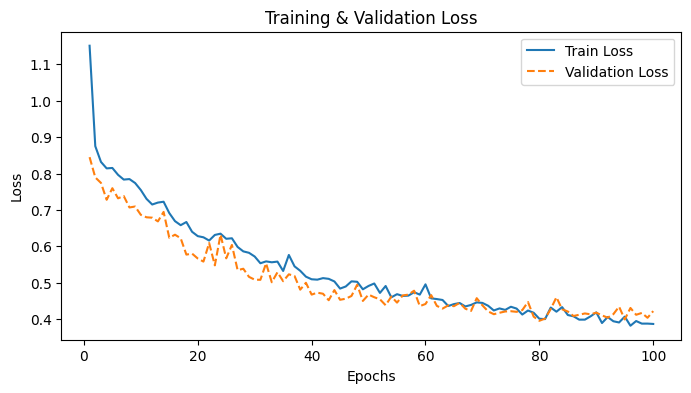

In [26]:
plt.figure(figsize=(8, 4))
sns.lineplot(x=epochs_range, y=train_losses, label='Train Loss', palette="coolwarm")
sns.lineplot(x=epochs_range, y=val_losses, label='Validation Loss', palette="coolwarm", linestyle="dashed")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

Plot dice score

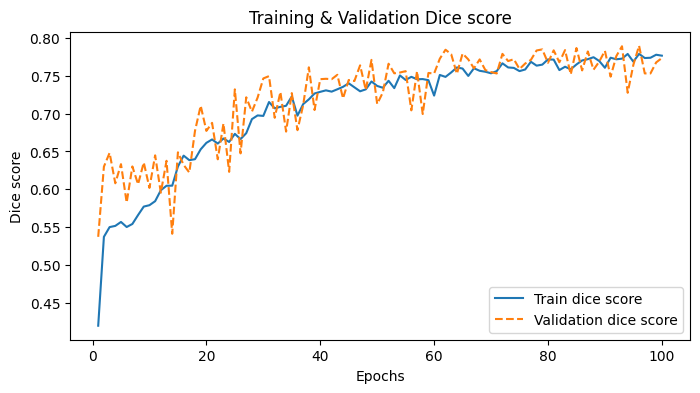

In [27]:
plt.figure(figsize=(8, 4))
sns.lineplot(x=epochs_range, y=train_dcs, label='Train dice score', palette="coolwarm")
sns.lineplot(x=epochs_range, y=val_dcs, label='Validation dice score', palette="coolwarm", linestyle="dashed")
plt.xlabel('Epochs')
plt.ylabel('Dice score')
plt.title('Training & Validation Dice score')
plt.legend()
plt.show()